In [1]:
# ID:sim_1 (hide)
import numpy as np # We use numpy.
np.random.seed(0) # To make this reproducible.

# Generate fake-data (simulation).
n = 20 # number of observations.
alpha = 0.9 # Parameter (can be changed).
beta = 0.4 # Parameter (can be changed).
sigma = 0.1 # Parameter (can be changed).

xs = np.random.normal(size = n) # random values for x.
pred = alpha + beta * xs # mean values for y.
ys = np.random.normal(scale = sigma, size = n) + pred # final output y.

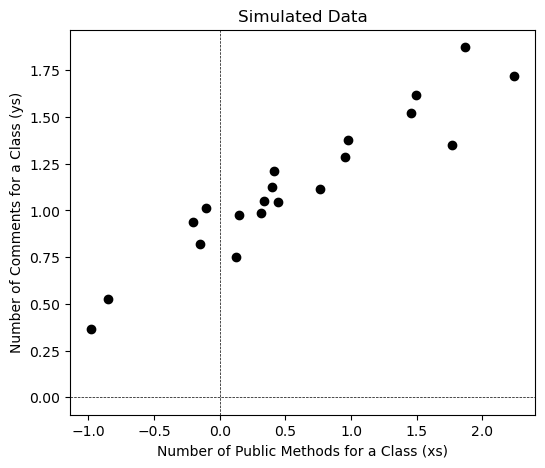

In [2]:
# OUT:sim_1 (hide)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(xs, ys, marker='o', linestyle='', color='black')

ax.set_xlabel('Number of Public Methods for a Class (xs)')
ax.set_ylabel('Number of Comments for a Class (ys)')

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)

ax.set_title('Simulated Data')
plt.show()

In [3]:
# ID:sklearn OUT:sklearn_out (HIDE)
# Implement the model using the scikit-learn library.
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(xs.reshape(-1, 1), ys) # FYI: Ugly reshape tensor needed:-(, from (20) to (20, 1).

# Print model summary (recovered parameters):
print("Intercept (alpha): ", model.intercept_)
print("Coefficient (betas): ", model.coef_)

Intercept (alpha):  0.89862396434804
Coefficient (betas):  [0.41220911]


In [4]:
# ID:tensorflow OUT:tensorflow_out (hide)
import tensorflow as tf # Using tensorflow core.
# Initialize the parameters (here 'variables').
alpha = tf.Variable(0.0); beta = tf.Variable(0.0)
xs_tf = tf.constant(xs, dtype=tf.float32) # to tensorflow ...
ys_tf = tf.constant(ys, dtype=tf.float32) # to tensorflow.
for i in range(1000): # Minimize 1000 steps.
    with tf.GradientTape() as tp: # Recorde gradients...
        # Define the loss (error) function on our own.
        pred_tf = alpha + beta * xs_tf # mean values for y.
        sum_squared_error = tf.reduce_sum(tf.pow(ys_tf - pred_tf, 2))
    # Minimize deriving error with respect to alpha and beta.
    gradients = tp.gradient(sum_squared_error, [alpha, beta])
    alpha.assign_sub(0.01 * gradients[0]) # gradient descent.
    beta.assign_sub(0.01 * gradients[1]) # gradient descent.
# (end)
print("Intercept (alpha): ", alpha.numpy())
print("Coefficient (betas): ", beta.numpy())

2024-02-19 12:19:52.622743: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 12:19:52.622820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 12:19:52.668929: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 12:19:52.738045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 12:19:57.938380: I exter

Intercept (alpha):  0.8986239
Coefficient (betas):  0.41220918


In [5]:
# ID:keras OUT:keras_out (hide)
import keras # Using keras API (on top of tensorflow).
import keras.layers as layers

# Single layer and a single output (a linear regression).
# The layer that may realize a linear model is a 'Dense'.
model = keras.Sequential([
        layers.Dense(units=1, input_shape=[1], activation='linear')
])

# Optimize using (stochastic) gradient descent optimizer.
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(xs, ys, epochs=1000, verbose=0)

# Print model summary (end)
print("Intercept (alpha): ", model.layers[0].get_weights()[1])
print("Coefficient (betas): ", model.layers[0].get_weights()[0])

2024-02-19 12:20:05.733238: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7134332be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-19 12:20:05.733296: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-02-19 12:20:05.795375: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
I0000 00:00:1708341605.873173   17519 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Intercept (alpha):  [0.89856374]
Coefficient (betas):  [[0.41226682]]


In [6]:
# ID:stan1 (hide)
# Using a (c++ like) DSL for model specification.
stan_code = """
data {
    int<lower=0> N; // number of observations.
    vector[N] xs; // input values (array).
    vector[N] ys; // output values (array).
}   
parameters { // Parameters we search for.
    real alpha; real beta;
    real<lower=0> sigma;
}
model { // Relationships between data and parameter.
    vector[N] pred;
    pred = alpha + beta * xs;
    ys ~ normal(pred, sigma);
}
"""

In [7]:
# ID:stan2 (hide)
import stan # Probabilistic programming language (STAN).

import nest_asyncio # (Hide)
nest_asyncio.apply() # To avoid the event loop related error (Hide)
# Run the Hamiltonian Monte Carlo (HMC) sampler to aproximate our 'error' function. Here "error" is a bit different and called the 'posterior' or '(probability) density'.
# Confusing, I know...
data = {'N': n, 'xs': xs, 'ys': ys}
model = stan.build(stan_code, data=data)
posterior = model.sample(num_chains=1, num_samples=4000)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100% (5000/5000)
Sampling: 100% (5000/5000), done.
Messages received during sampling:
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_fh_h83ks/model_wtbhn7fh.stan', line 14, column 4 to column 29)
  If this warning occurs sporadically, such as for highly constrained variable ty

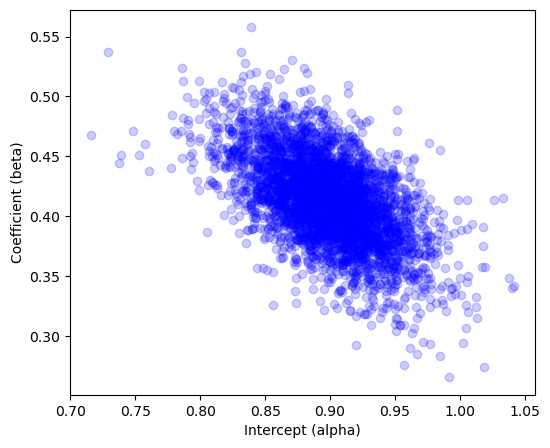

In [8]:
# OUT:stan3 (hide)
# Plotting the posterior samples.
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(posterior['alpha'][0], posterior['beta'][0], marker='o', color='blue', alpha=0.2)

ax.set_xlabel('Intercept (alpha)')
ax.set_ylabel('Coefficient (beta)')

plt.show()